In [25]:
import pandas as pd
import numpy as np
import pickle
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool,ColumnDataSource,TapTool

from sklearn.preprocessing import MinMaxScaler as minmax

from bokeh.models.callbacks import CustomJS
from bokeh.io import curdoc
from bokeh import events

from bokeh.layouts import row,column,layout,widgetbox
from bokeh.palettes import Category10
from bokeh.models import LinearInterpolator
from bokeh.models.mappers import LinearColorMapper
from bokeh.models.widgets import Slider

import matplotlib.pyplot as plt

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [26]:
df=pd.read_csv('./Fashion_Mnist_900.csv')
df['preds']=df['preds']
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,776,777,778,779,780,781,782,783,label,preds
0,0,0,0,0,0,0,0,0,9,8,...,56,0,0,0,0,0,0,0,0,6
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
2,2,0,0,0,0,0,0,14,53,99,...,0,0,63,53,31,0,0,0,2,6
3,3,0,0,0,0,0,0,0,0,0,...,140,0,133,224,222,56,0,0,2,6
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3


In [27]:
accuracy=np.mean(df['label']==df['preds'])
accuracy

0.28339999999999999

In [28]:
images_df=df.iloc[:,:-3]
images_df.shape
images=images_df.as_matrix().astype(np.float64)
images=minmax().fit_transform(images)

images_list=[]
for i in range(images.shape[0]):
    images_list.append(np.flip(images[i,:].reshape(28,28),axis=0))

xs=np.random.random((len(images_list))).tolist()
ys=np.random.random((len(images_list))).tolist()    

df['xs']=xs
df['ys']=ys
df['images']=images_list

In [29]:
df['images'][100].shape

(28, 28)

In [30]:
first_df=df.loc[df['label']==1,:]
first_df.reset_index(inplace=True)
first_df.shape,Category10[10]

((1000, 791),
 ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf'])

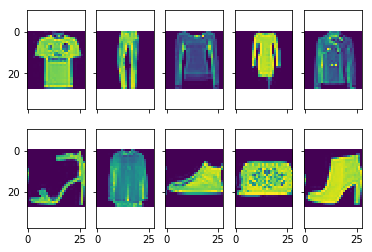

In [38]:
f, axarr = plt.subplots(2,5,sharex=True,sharey=True)
for i in range(2):
    for j in range(5):
        first_df=df.loc[df['label']==(i*5+j),:]
        first_df.reset_index(inplace=True)
        image_=np.flip(first_df.loc[0,'images'].reshape(28,28),axis=0)
        axarr[i,j].imshow(image_)
plt.show()        

In [24]:
first_df=df.loc[df['label']==1,:]
first_df.reset_index(inplace=True)
data_source=ColumnDataSource(data=dict(xs=[],ys=[],color=[],\
                                       size=[],images=[]))

images_source=ColumnDataSource(data=dict(images=[]))

scatter_plot=None
img=None
slider=None
slider2=None

def update_plot(attr,old,new):
    global slider,df,data_source
    filtered=df.loc[df['preds']==slider.value,:]
    filtered.reset_index(inplace=True)
    
    data_source.data['xs']=filtered['xs']
    data_source.data['ys']=filtered['ys']
    data_source.data['color']=filtered['preds']
    data_source.data['size']=filtered['label']
    data_source.data['images']=filtered['images']
    
def update_plot2(attr,old,new):
    global slider2,df,data_source
    filtered=df.loc[df['label']==slider2.value,:]
    filtered.reset_index(inplace=True)
        
    data_source.data['xs']=filtered['xs']
    data_source.data['ys']=filtered['ys']
    data_source.data['color']=filtered['preds']
    data_source.data['size']=filtered['label'] 
    data_source.data['images']=filtered['images']
    
tap_callback = CustomJS(args=dict(source=data_source,source2=images_source),code="""
        var selected = source.selected['1d'].indices;
        console.log(cb_data.source,cb_data.geometries,selected[0]);
        var data =cb_data.source['data'];
        var data2=source2['data'];
        var ind0 =selected[0];
        var arr=data['images'][ind0]
        var newArr = [];
        while(arr.length) 
            newArr.push(arr.splice(0,28));             
             data2['images']=newArr;       
             source2.change.emit();
    """)


slider = Slider(start=0, end=9, value=1, step=1, title="Predicted class")
slider.on_change('value', update_plot)

slider2 = Slider(start=0, end=9, value=1, step=1, title="True class")
slider2.on_change('value', update_plot2)

hover=HoverTool(tooltips=[('Pred:',"@color"),\
                          ('TrueLabel:','@size')],show_arrow=False)

tap=TapTool(callback=tap_callback)

size_mapper=LinearInterpolator(x=[0,9],\
      y=[5,15])

color_mapper=LinearColorMapper(low=0,\
                               high=9,\
                              palette=Category10[10])

scatter_plot=figure(toolbar_location='above',plot_width=600,plot_height=500)
scatter_plot.circle('xs','ys',source=data_source,fill_color={'field':'color','transform':color_mapper},\
                    size={'field':'size','transform':size_mapper})

#add js event click.
scatter_plot.add_tools(hover)
scatter_plot.add_tools(tap)
#scatter_plot.js_on_event(events.Tap,hover_callback) 

img = figure(x_range=(0,10),y_range=(0,10),tools=['hover'], toolbar_location='above',plot_width=600,plot_height=500)
img.image(image='images', x=0, y=0, dw=10, dh=10,palette='Greys7',source=images_source)
img.axis.visible=False
l=column(row(scatter_plot,img),row(widgetbox(slider,slider2)))
curdoc().add_root(l)
show(l)
#plt.imshow(images[1,:].reshape(28,28),cmap='gray')
#plt.show()